In [12]:
%pip install langgraph -q
%pip install openai -q
%pip install langchain-openai -q
%pip install langchain-community -q
%pip install python-dotenv -q


[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [13]:
from dotenv import load_dotenv
_ = load_dotenv()

In [14]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

In [15]:
tool = TavilySearchResults(max_results=2) #increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


In [16]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

Note: in take_action below, some logic was added to cover the case that the LLM returned a non-existent tool name. Even with function calling, LLMs can still occasionally hallucinate. Note that all that is done is instructing the LLM to try again! An advantage of an agentic organization.

In [17]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [18]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(model="gpt-3.5-turbo")  #reduce inference cost
abot = Agent(model, [tool], system=prompt)

In [24]:
%pip install -U --no-cache-dir  \
            --config-settings="--global-option=build_ext" \
            --config-settings="--global-option=-I$(brew --prefix graphviz)/include/" \
            --config-settings="--global-option=-L$(brew --prefix graphviz)/lib/" pygraphviz -q


[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


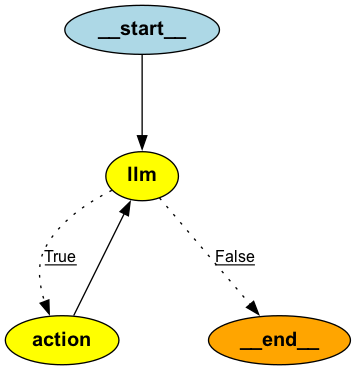

In [25]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

In [26]:
messages = [HumanMessage(content="What is the weather in sf?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_PYgOm6ihJRVpYIi8VR4UQ3wE', 'type': 'tool_call'}
Back to the model!


In [27]:
result

{'messages': [HumanMessage(content='What is the weather in sf?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_PYgOm6ihJRVpYIi8VR4UQ3wE', 'function': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 153, 'total_tokens': 175, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-4f6f246d-fa6b-417c-8a3b-9ecbdd2b233e-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_PYgOm6ihJRVpYIi8VR4UQ3wE', 'type': 'tool_call'}], usage_metadata=

In [28]:
result['messages'][-1].content

'The current weather in San Francisco is partly cloudy with a temperature of 50.4°F (10.2°C). The wind speed is 6.0 mph (9.7 kph) coming from the west-northwest direction. The humidity is at 80% and the visibility is 9.0 miles.'

In [29]:
# This is example of parallel tool calling as it's performing both the queries in parallel before going to the model.
messages = [HumanMessage(content="What is the weather in SF and LA?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_OlaRwNxn6CVj3JpEyorOeQq0', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Los Angeles'}, 'id': 'call_MOP4gJuHNIWvrW4SDuQjkcX1', 'type': 'tool_call'}
Back to the model!


In [30]:
result['messages'][-1].content

'The current weather in San Francisco is partly cloudy with a temperature of 50.4°F (10.2°C) and a wind speed of 9.7 kph. In Los Angeles, it is clear with a temperature of 52.0°F (11.1°C) and a wind speed of 3.6 kph.'

In [31]:
# Note, the query was modified to produce more consistent results. 
# Results may vary per run and over time as search information and models change.
# Example of sequential tool calling as it's performing the queries in sequence because second query needs result of first query.
query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question." 
messages = [HumanMessage(content=query)]

model = ChatOpenAI(model="gpt-4o")  # requires more advanced model
abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Who won Super Bowl 2024'}, 'id': 'call_taOFfXna7jOssheGRXIwuBYO', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Kansas City Chiefs headquarters location'}, 'id': 'call_MmPlm20bAyBBjcpCVJwd4Kch', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Missouri GDP 2024'}, 'id': 'call_QedLLvtiz3apetSHZ6AvyXQF', 'type': 'tool_call'}
Back to the model!


In [ ]:
print(result['messages'][-1].content)